<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/main/LULC_Classification_Magdalena_using_Polygons_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.3 MB/s eta 0:00:00


In [15]:
# Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import rasterio
import earthpy.plot as ep
from matplotlib.colors import from_levels_and_colors
import ee

In [4]:
# Parameter
FEATURES = ['VV', 'VH','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9','B11', 'B12', 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev', 'slope'] # 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev'
LABEL = ['class']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [0, 1, 2, 3, 4, 5]
PALETTE = ['006400', 'f096ff', '42c447', 'b5ac89', 'ffff4c', '0064c8']
SAMPLE_PATH = '/content/drive/MyDrive/s1s2_magdalena/Samples_LC_Magdalena_2020_polys.csv'
IMAGE_PATH = '/content/drive/MyDrive/s1s2_magdalena/S1S2_Magdalena_2020.tif'

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


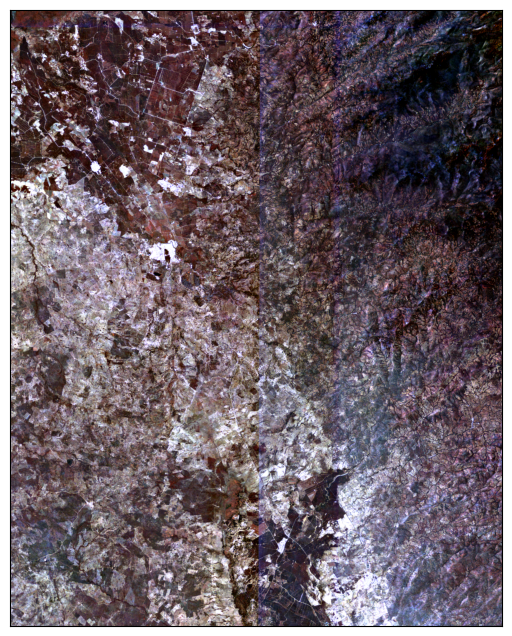

<Axes: >

In [5]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [5,4,3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [6]:
print(bandNum,len(FEATURES))

22 22


In [7]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data


In [8]:
samples

,VV,VH,B1,B2,B3,B4,B5,B6,B7,B8,...,ndvi,ndbi,mndwi,ndwi,bsi,evi,elev,slope,class,sample
881,-5.530348,-14.547615,1039.000000,1192.000000,1498.000000,1525.500000,1835.5,2476.500000,2819.500000,2796.000000,...,0.293995,0.050272,-0.347277,-0.302282,0.073151,1.055233,46,0.000000,5,test
525,-11.309334,-16.976587,693.000000,824.500000,1094.500000,1077.000000,1687.5,2620.000000,3115.000000,3128.000000,...,0.487753,0.031879,-0.505702,-0.481587,0.054822,1.504879,40,1.322788,1,train
427,-5.035820,-13.298680,258.000000,257.000000,420.000000,241.000000,635.0,2012.000000,2485.000000,2619.000000,...,0.831469,-0.383153,-0.471033,-0.723593,-0.342357,2.779986,1558,4.155249,0,test
486,-8.018818,-14.095875,402.000000,617.000000,999.000000,1149.000000,1597.5,2778.500000,3182.000000,3418.500000,...,0.496880,-0.052332,-0.509994,-0.547708,0.023236,0.997846,330,9.606367,1,train
434,-5.324614,-12.790058,165.500000,216.000000,401.500000,232.000000,663.0,1956.500000,2503.000000,2691.500000,...,0.841286,-0.356603,-0.521454,-0.740382,-0.316803,2.494928,1563,9.084506,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-6.131526,-13.737164,238.833333,314.000000,600.666667,332.500000,1055.0,2734.250000,3307.500000,3409.000000,...,0.822264,-0.244198,-0.550315,-0.700391,-0.215409,2.521721,269,12.801735,0,train
846,-23.932416,-27.610260,227.000000,316.000000,462.000000,525.000000,742.0,406.000000,422.000000,338.000000,...,-0.216686,-0.417191,0.537438,0.155000,0.007587,-0.417784,100,0.000000,4,train
871,-6.069995,-11.749635,1363.833333,1593.200000,1827.250000,1947.333333,2143.0,2119.111111,2149.666667,2136.428571,...,0.046304,0.173483,-0.248128,-0.078003,0.143623,0.252473,960,6.464861,5,train
666,-8.126035,-15.960488,210.000000,265.666667,484.000000,254.000000,812.0,2843.750000,3689.666667,3691.000000,...,0.871229,-0.364006,-0.560998,-0.768144,-0.334083,2.665581,134,0.927410,2,train


In [9]:
class_counts = samples['class'].value_counts()
total_rows = samples.shape[0]

for class_label, count in class_counts.items():
  print(f"Class {class_label}: {count}")

print(f"Total rows: {total_rows}")

Class 0: 461
Class 1: 177
Class 2: 132
Class 3: 62
Class 5: 28
Class 4: 23
Total rows: 883


In [10]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Convert samples dataframe (pandas) to numpy array
train_input = train_features.to_numpy()
test_input = test_features.to_numpy()

# Make label data categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')


Train features: (740, 22)
Test features: (143, 22)
Train label: (740, 6)
Test label: (143, 6)


In [11]:
# Create MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(len(FEATURES),)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5888      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [13]:
# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=32,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
24/24 [==============================] - 2s 16ms/step - loss: 341.0794 - accuracy: 0.3270 - val_loss: 46.3217 - val_accuracy: 0.6224
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 108.7165 - accuracy: 0.4351 - val_loss: 13.7264 - val_accuracy: 0.5944
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 64.8172 - accuracy: 0.4568 - val_loss: 12.8361 - val_accuracy: 0.4895
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 45.6635 - accuracy: 0.5108 - val_loss: 6.3275 - val_accuracy: 0.5734
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 34.8207 - accuracy: 0.5081 - val_loss: 5.9078 - val_accuracy: 0.5594
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 32.0089 - accuracy: 0.4676 - val_loss: 4.3980 - val_accuracy: 0.5245
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 22.6936 - accuracy: 0.5216 - val_loss: 7.0292 - val_accuracy: 0.6643


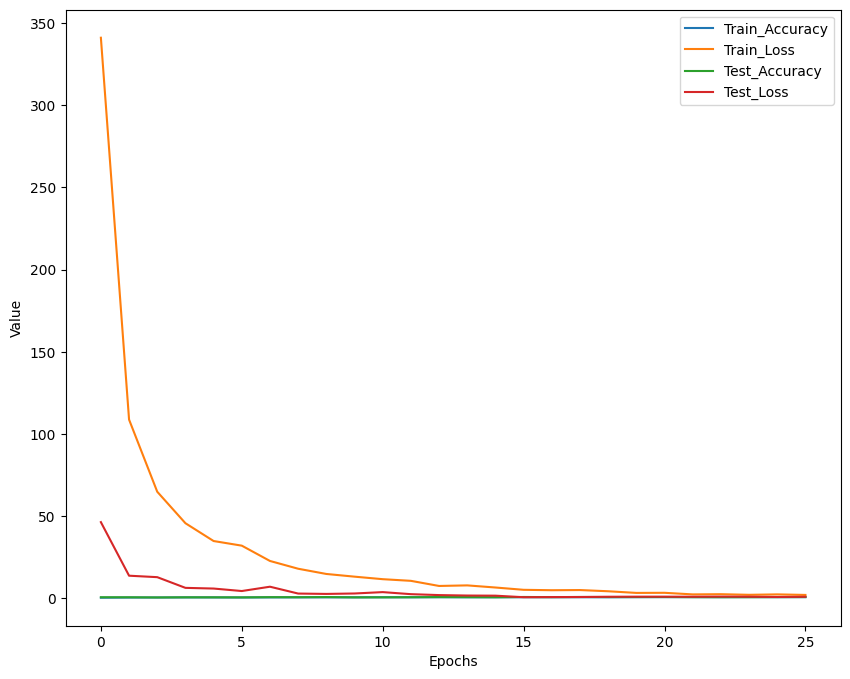

In [14]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(history['accuracy'], label = 'Train_Accuracy')
plt.plot(history['loss'], label = 'Train_Loss')
plt.plot(history['val_accuracy'], label = 'Test_Accuracy')
plt.plot(history['val_loss'], label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

5/5 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        80
           1       1.00      0.35      0.52        17
           2       0.44      1.00      0.61        14
           3       0.93      0.67      0.78        21
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         8

    accuracy                           0.78       143
   macro avg       0.87      0.75      0.76       143
weighted avg       0.84      0.78      0.78       143



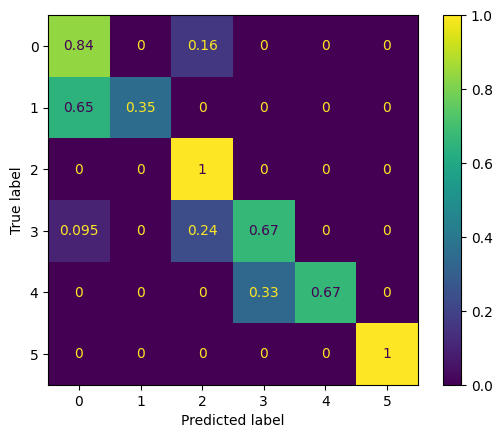

In [17]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1)
label = np.argmax(test_output, 1)

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
# print("Confusion Matrix:")
# print(cm)
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print("\nClassification Report:")
print(classification_report(label, prediction))


64/64 [==============================] - 16s 246ms/step


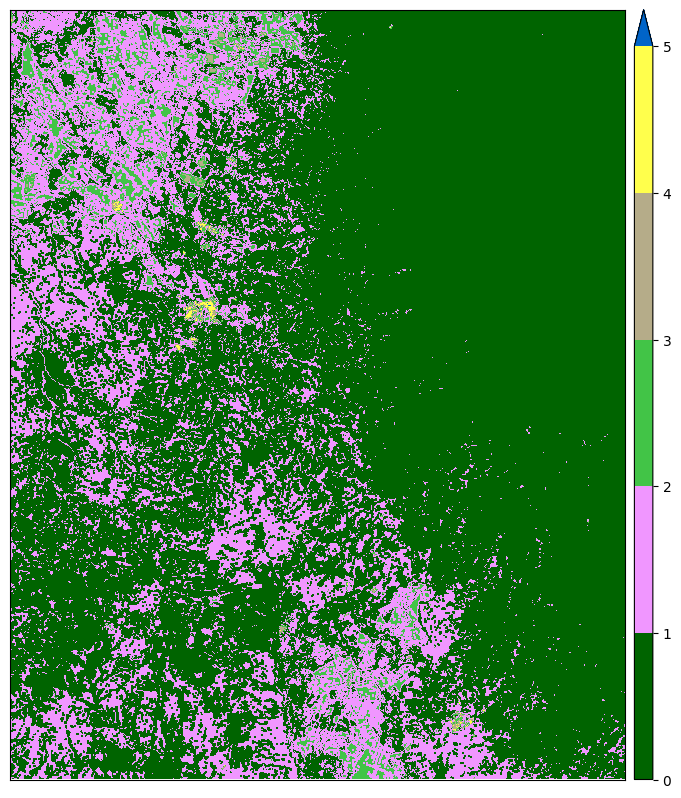

In [18]:
# Predict image using the model
image_input = []
for x in range(len(FEATURES)):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(len(FEATURES), -1).T

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
PALETTE = ['#' + color if not color.startswith('#') else color for color in PALETTE]
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(10, 10))
plt.show()


In [19]:
# Save file to drive
save_location = '/content/drive/MyDrive/s1s2_magdalena/'
name = 'LC_Magdalena_2020_MLP_poly.tif'
location = save_location + name

new_dataset = rasterio.open(
    location,
    mode='w', driver='GTiff',
    height = prediction.shape[0], width = prediction.shape[1],
    count=1, dtype=str(prediction.dtype),
    crs=crs,
    transform=transform
)
new_dataset.write(prediction, 1)
new_dataset.close()